# МКЭ для решения линейного эллиптического уравнения

## Задача c граничными условиями Дирихле

Необходимо найти поле перемещений $u(x)$ в балке длиной $L=1[м]$, один конец которой зафиксирован, а второй перемещен на 0.01[м]. Балка испытывает инерционную нагрузку от ускорения $a=100[м/c^2]$. Плотность балки распределена по закону $\rho(x) = x + 2.7e7[кг/м^3]$. Модуль Юнга балки $E = 70e9[Па]$.

![fd_1d_task_1](../images/fd_1d_task_1.svg)


### Формулировка математической модели:

\begin{align}
&\frac{\partial}{\partial x} \left( E \frac{\partial u}{\partial x}\right) + f = 0 \\
&u(0) = 0, u(1) = 0.01 \\
&E = 70e9 \\
&f = a * \rho(x) = f_a * x + f_b = 1e2 * x + 2.7e9
\end{align}

### Аналитическое решение

In [1]:
import sympy as sp
sp.init_printing()

u = sp.Function('u')
x = sp.symbols('x')

E = 70000000000
f_a = 100
f_b = 2700000000
f =  f_a * x + f_b
u_s = 0
u_t = 0.01

equation = (E * u(x).diff(x, 1)).diff(x, 1) + f

exact = sp.dsolve(equation, 
                  ics={u(0):u_s,
                       u(1):u_t})
display(exact)

Text(0, 0.5, 'u')

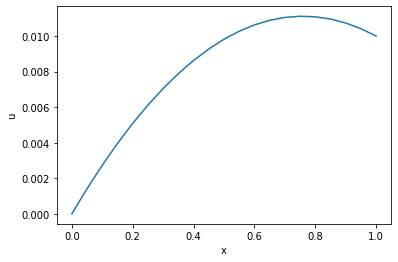

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x_exact = np.arange(0., 1.05, 0.05)
plt.plot(x_exact, [exact.rhs.subs({x:i}) for i in x_exact])
plt.xlabel('x')
plt.ylabel('u')

### Численное решение

Для общности и краткости изложения запишем уравнение через оператор Лапласа:

\begin{align}
E \nabla^2 u + f = 0.
\end{align}

1. Переход к вариационной формулировке задачи:

* Введем весовые функции $v$ принадлежащие пространству функций $\hat{V} = \{v \in H^1(\Omega)|v = 0;  x \in \partial\Omega_u\}$, где $\Omega$ - вычислительный домен; $\partial\Omega_u$ - граница домена, на которой заданы граничные условия Дирихле; $H^1(\Omega)$ - Соболевское функциональное пространство. 

* Умножим уравнение на весовую функцию $v$ и интегрируем по всему домену $\Omega$:

\begin{align}
\int_{\Omega} E \nabla^2 u v dx + \int_{\Omega} f v dx   = 0.
\end{align}

* Используем интегрирование по частям, чтобы понизить степень производной:

\begin{align}
-\int_{\Omega} E \nabla u \nabla v dx + \int_{\partial\Omega} E \frac{\partial u}{\partial n} v dS + \int_{\Omega} f v dx   = 0.
\end{align}

\begin{align}
\int_{\Omega} E \nabla u \nabla v dx = \int_{\partial\Omega} E \frac{\partial u}{\partial n} v dS + \int_{\Omega} f v dx.
\end{align}

* Выберем пространство функций, которому принадлежит решение:

\begin{align}
V = \{u \in H^1(\Omega)|u = u_g;  x \in \partial\Omega_u\}
\end{align}

2. Операторная формулировка вариационной задачи:

\begin{align}
a(u, v) = L(v) \\
v \in \hat{V}, u \in V,
\end{align}

где

\begin{align}
a(u, v) &= \int_{\Omega} E \nabla u \nabla v dx \\
L(v) &=  \int_{\partial\Omega} E \frac{\partial u}{\partial n} v dS + \int_{\Omega} f v dx.
\end{align}

3. Построим сетку:

In [3]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_interval(MPI.COMM_WORLD, 8, [0, 1])

4. Введем пространство функций для Лагражева семейства конечных элементов ("CG") с одной степенью свободы в узле:

In [4]:
from dolfinx.fem import FunctionSpace
V = FunctionSpace(domain, ("CG", 1))

5. Введем функцию решения и функцию весов:

In [5]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

6. Создадим билинейную форму вариационной задачи $a(u, v)$:

In [6]:
from dolfinx.fem import Constant, Function
from petsc4py.PETSc import ScalarType

E = Constant(domain, ScalarType(70e9))

a = ufl.inner(E * ufl.grad(u), ufl.grad(v)) * ufl.dx

7. Создадим линейную форму задачи $L(v)$:

In [7]:
f = Function(V)
f.interpolate(lambda x: 1e2 * x[0] + 2.7e9)

L = ufl.inner(f, v) * ufl.dx

8. Создадим систему граничных условий Дирихле

In [8]:
from dolfinx.fem import locate_dofs_geometrical, dirichletbc
from petsc4py.PETSc import ScalarType
import numpy as np

dofs_L = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
dofs_R = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 1.))

bc_L = dirichletbc(ScalarType(0), dofs_L, V)
bc_R = dirichletbc(ScalarType(0.01), dofs_R, V)

9. Решим линейную систему

In [9]:
import dolfinx.fem as fem
problem = fem.petsc.LinearProblem(a, L, bcs=[bc_L, bc_R], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

10. Анализ результата

Text(0, 0.5, 'u')

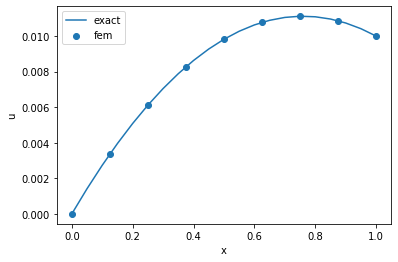

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(x_exact, [exact.rhs.subs({x:i}) for i in x_exact], label='exact')
x_nodes = np.arange(0., 1. + 1. / 8., 1. / 8.)
plt.scatter(x_nodes, uh.x.array.real, label='fem')
plt.legend()
plt.xlabel('x')
plt.ylabel('u')

## Задача c граничным условием Неймана


Необходимо найти поле перемещений $u(x)$ в балке длиной $L=1[м]$, один конец которой зафиксирован, а ко второму приложена сила растягивающая напряжение $t = 1e9[Па]$. Балка испытывает инерционную нагрузку от ускорения $a=100[м/c^2]$. Плотность балки распределена по закону $\rho(x) = x + 2.7e7[кг/м^3]$. Модуль Юнга балки $E = 70e9[Па]$.

![fd_1d_task_2](../images/fd_1d_task_2.svg)

### Формулировка математической модели

\begin{align}
&\frac{\partial}{\partial x} \left( E \frac{\partial u}{\partial x} \right) + f = 0 \\
&u(0) = 0, \left.E\frac{\partial u(x)}{\partial x}\right|_{x=1}  = t \\
&E = 70e9 \\
&f = a * \rho(x) = f_a * x + f_b = 1e2 * x + 2.7e9 \\
&t = -1.
\end{align}


### Аналитическое решение

In [11]:
import sympy as sp
sp.init_printing()

u = sp.Function('u')
x = sp.symbols('x')

E = 70000000000
f_a = 100
f_b = 2700000000
f =  f_a * x + f_b
u_s = 0.
t = 1e9

equation = (E * u(x).diff(x, 1)).diff(x, 1) + f

exact = sp.dsolve(equation,
                  ics={u(0):u_s, 
                       u(x).diff(x).subs(x, 1):t / E})
display(exact)

In [18]:
from mpi4py import MPI
from dolfinx import mesh
num_elements = 8
domain = mesh.create_interval(MPI.COMM_WORLD, num_elements, [0, 1])

from dolfinx.fem import FunctionSpace
V = FunctionSpace(domain, ("CG", 1))

import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

from dolfinx.fem import Constant, Function
from petsc4py.PETSc import ScalarType

E = Constant(domain, ScalarType(70e9))

a = ufl.inner(E * ufl.grad(u), ufl.grad(v)) * ufl.dx

Подготовим субдомен границы, на котором прикладываются граничные условия Неймана:

In [13]:
from dolfinx.mesh import locate_entities_boundary
from dolfinx.mesh import meshtags

right_boundary = locate_entities_boundary(domain, domain.topology.dim-1, lambda x: np.isclose(x[0], 1.))
mesh_tags = meshtags(domain, domain.topology.dim-1, right_boundary, 1)
dS = ufl.Measure('ds', subdomain_data=mesh_tags, domain=domain)

In [14]:
f = fem.Function(V)
f.interpolate(lambda x: 1e2 * x[0] + 2.7e9)

t = Constant(domain, ScalarType(1e9))
L = ufl.inner(f, v) * ufl.dx + ufl.inner(t, v) * dS(1)

In [19]:
from dolfinx.fem import locate_dofs_geometrical, dirichletbc
from petsc4py.PETSc import ScalarType
import numpy as np

dofs_L = locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
bc_L = dirichletbc(ScalarType(0), dofs_L, V)

In [20]:
import dolfinx.fem as fem
problem = fem.petsc.LinearProblem(a, L, bcs=[bc_L], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

Text(0, 0.5, 'u')

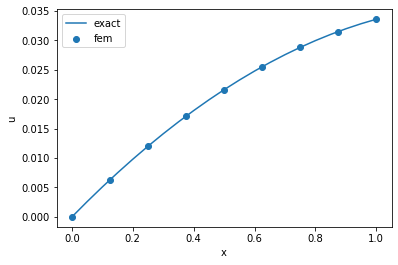

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
x_nodes = np.arange(0., 1. + 1. / num_elements, 1. / num_elements)
plt.plot(x_exact, [exact.rhs.subs({x:i}) for i in x_exact], label='exact')
plt.scatter(x_nodes, uh.x.array.real, label='fem')
plt.legend()
plt.xlabel('x')
plt.ylabel('u')